### Variational Inference from scratch in JAX

In [1]:
try:
    import jax
    import jax.numpy as jnp
except:
    ModuleNotFoundError
    %pip install jax jaxlib
    import jax
    import jax.numpy as jnp

try:
    from tensorflow_probability.substrates import jax as tfp
except:
    ModuleNotFoundError
    %pip install tensorflow_probability
    from tensorflow_probability.substrates import jax as tfp

try:
    import optax
except:
    ModuleNotFoundError
    %pip install optax
    import optax

try:
    from rich import print
    from rich.table import Table
except:
    ModuleNotFoundError
    %pip install rich
    from rich import print
    from rich.table import Table


import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
dist = tfp.distributions

In [3]:
key = jax.random.PRNGKey(0)

### Unnormalized distribution to be approximated

In [4]:
p = dist.MixtureSameFamily(
    mixture_distribution=dist.Categorical(probs=jnp.array([0.5, 0.5])),
    components_distribution=dist.Normal(
        loc=jnp.array([-0.2, 1]), scale=jnp.array([0.4, 0.5])  # One for each component.
    ),
)

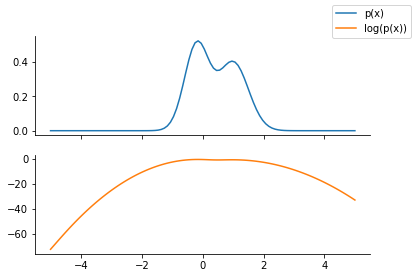

In [5]:
x = jnp.linspace(-5.0, 5.0, 100)
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(x, p.prob(x), label="p(x)", color="C0")
ax[1].plot(x, p.log_prob(x), label="log(p(x))", color="C1")
fig.legend()
sns.despine()

### Computing KL-divergence

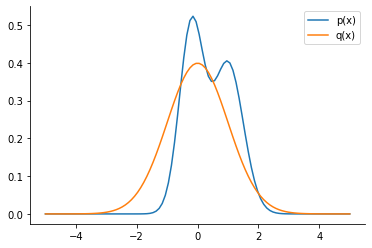

In [6]:
q = dist.Normal(loc=0.0, scale=1.0)
plt.plot(x, p.prob(x), label="p(x)", color="C0")
plt.plot(x, q.prob(x), label="q(x)", color="C1")
plt.legend()
sns.despine()

In [7]:
try:
    dist.kl_divergence(p, q)
except Exception as e:
    print(e)

No KL(distribution_a || distribution_b) registered for distribution_a type MixtureSameFamily 
and distribution_b type Normal

#### Monte Carlo Sampling

In [8]:
def kl_via_sampling(p, q, n_samples=1000):
    key = jax.random.PRNGKey(1)
    # Get samples from q
    sample_set = q.sample(
        seed=key,
        sample_shape=[
            n_samples,
        ],
    )
    # Use the definition of KL-divergence
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [9]:
klv = kl_via_sampling(p, q)
klv

DeviceArray(0.7333999, dtype=float32)

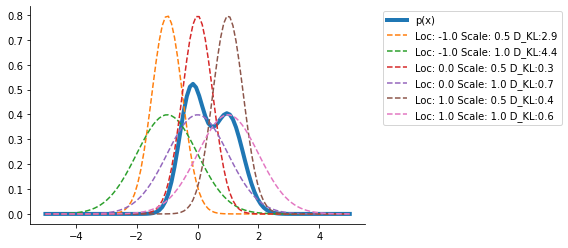

In [10]:
plt.plot(x, p.prob(x), label="p(x)", lw=4)


out = {}
for loc in [-1.0, 0.0, 1.0]:
    out[loc] = {}
    for scale in [0.5, 1.0]:
        q_loc_scale = dist.Normal(loc=loc, scale=scale)
        out[loc][scale] = kl_via_sampling(p, q_loc_scale)
        plt.plot(
            x,
            q_loc_scale.prob(x),
            label=f"Loc: {loc} Scale: {scale} D_KL:{out[loc][scale]:0.1f}",
            ls="--",
        )

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
sns.despine()

Clearly, the <loc = 0., scale = 0.5> seems the closest from the range of distributions we have tried. 

### Reparameterization

We use the following concept: 

1. We parameterize q via its parameters (which we now learn)
2. We generate the samples from a standard normal distribution and then rescale them for q's location and scale
3. Our KL-divergence and hence the loss is a function of the parameters of q and thus we can use autograd functionality

In [11]:
def kl_reparam(p, q_loc, q_scale, n_samples=1000):
    key = jax.random.PRNGKey(1)
    q = dist.Normal(loc=q_loc, scale=q_scale)
    std_normal = dist.Normal(loc=0.0, scale=1.0)
    sample_set = std_normal.sample(
        seed=key,
        sample_shape=[
            n_samples,
        ],
    )
    sample_set = q_loc + q_scale * sample_set
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [12]:
klv_rep = kl_reparam(p, 0.0, 1.0)

In [13]:
klv_rep, klv

(DeviceArray(0.7333999, dtype=float32), DeviceArray(0.7333999, dtype=float32))

We can confirm that the KL-divergence we obtain via generating samples directly from q or via generating samples from standard normal and then scaling are the same

### Optimizing the ELBO

I first redefine the function to make use of a dictionary instead of passing them as separate arguments.

In [14]:
@jax.jit
def kl_reparam(p, params, n_samples=1000, key = jax.random.PRNGKey(1)):
    q_loc, q_scale = params["loc"], params["scale"]
    q = dist.Normal(loc=q_loc, scale=q_scale)
    std_normal = dist.Normal(loc=0.0, scale=1.0)
    sample_set = std_normal.sample(
        seed=key,
        sample_shape=[
            n_samples,
        ],
    )
    sample_set = q_loc + scale * sample_set
    return jnp.mean(q.log_prob(sample_set) - p.log_prob(sample_set))

In [15]:
grad_loss = jax.grad(kl_reparam, argnums=(1))

In [16]:
params = {"loc": jnp.array([5.0]), "scale": jnp.array([1.0])}


grad_theta_val = grad_loss(p, params)
grad_theta_val

{'loc': DeviceArray([15.805946], dtype=float32),
 'scale': DeviceArray([0.00562394], dtype=float32)}

In [17]:
optimizer = optax.sgd(learning_rate=0.01)
opt_state = optimizer.init(params)

In [18]:
import numpy as np

num_iter = 100
costs = np.empty(num_iter)
key = jax.random.PRNGKey(1)
for i in range(num_iter):
    key, subkey = jax.random.split(key)
    cost_val = kl_reparam(p, params, key = subkey)
    costs[i] = cost_val
    grads = grad_loss(p, params)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

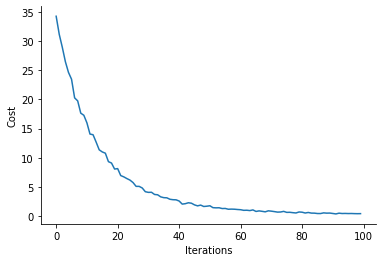

In [19]:
plt.plot(costs)
plt.xlabel("Iterations")
plt.ylabel("Cost")
sns.despine()

In [20]:
params

{'loc': DeviceArray([0.79362154], dtype=float32),
 'scale': DeviceArray([0.9817765], dtype=float32)}

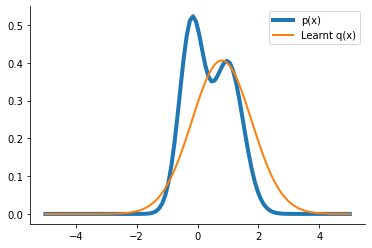

In [21]:
q_learnt = dist.Normal(loc=params["loc"], scale=params["scale"])
plt.plot(x, p.prob(x), label="p(x)", lw=4)
plt.plot(x, q_learnt.prob(x), label="Learnt q(x)", lw=2)
plt.legend()
sns.despine()